In [340]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from scipy.optimize import minimize
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.spatial.distance import minkowski
from decimal import Decimal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import log2

plt.rcParams["figure.figsize"] = (16, 9)

df = pd.read_csv('train.csv')
print(df.shape)
df.head(10)

(206474, 76)


,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type
0,Ставрополь,NaN,COL_65683,45.011356,41.919273,7,71,144,225,0,...,969.0,8.439655,9.250000,1990.232759,1993.500000,Ставропольский край,31.0,S1842,2020-02-23,10
1,Омск,NaN,COL_159011,54.984833,73.387344,4,40,109,206,0,...,305.0,4.756410,4.333333,1960.346154,1956.291667,Омская область,150.0,S14290,2020-05-24,10
2,Белгород,NaN,COL_205850,50.576805,36.563267,0,9,22,44,0,...,533.0,6.435897,6.400000,1980.452991,1989.633333,Белгородская область,73.0,S25733,2020-06-28,10
3,Большой Исток,NaN,COL_229491,56.714413,60.792454,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,Свердловская область,438.0,S6985,2020-07-19,110
4,Новосибирск,1.0,COL_77283,55.055200,82.895810,0,25,50,101,0,...,1188.0,6.830065,6.672414,1974.045752,1974.637931,Новосибирская область,62.7,S4778,2020-03-01,10
5,Красноярск,1.0,COL_237766,56.054585,92.923680,3,15,39,66,0,...,488.0,11.113924,11.000000,2004.949367,2010.062500,Красноярский край,84.0,S2682,2020-07-26,100
6,Москва,2.0,COL_188715,55.861176,37.549427,1,39,96,133,0,...,16.0,14.909091,16.000000,1994.272727,1969.000000,Москва,623.0,S7194,2020-06-14,110
7,Волгоград,NaN,COL_77130,48.676510,44.472553,16,84,90,97,0,...,1063.0,8.827586,9.148936,1983.086207,1981.659574,Волгоградская область,70.0,S26181,2020-03-01,10
8,Белгород,1.0,COL_216454,50.557530,36.565690,1,27,65,85,0,...,1750.0,9.971429,10.660000,1999.809524,1999.360000,Белгородская область,68.0,S4639,2020-07-05,110
9,Иркутск,NaN,COL_262955,52.270250,104.310104,0,26,66,97,0,...,1073.0,6.338843,6.073529,1971.798354,1977.470588,Иркутская область,608.0,S19079,2020-08-16,10


In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206474 entries, 0 to 206473
Data columns (total 76 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   city                                 206474 non-null  object 
 1   floor                                76209 non-null   float64
 2   id                                   206474 non-null  object 
 3   lat                                  206474 non-null  float64
 4   lng                                  206474 non-null  float64
 5   osm_amenity_points_in_0.001          206474 non-null  int64  
 6   osm_amenity_points_in_0.005          206474 non-null  int64  
 7   osm_amenity_points_in_0.0075         206474 non-null  int64  
 8   osm_amenity_points_in_0.01           206474 non-null  int64  
 9   osm_building_points_in_0.001         206474 non-null  int64  
 10  osm_building_points_in_0.005         206474 non-null  int64  
 11  osm_building_

In [342]:
df.describe()

,floor,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,...,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,total_square,realty_type
count,76209.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,...,206474.000000,206474.000000,195541.000000,186141.000000,193961.000000,183936.000000,194311.000000,184340.000000,206474.000000,206474.000000
mean,1.856802,54.343090,47.505203,2.686672,40.283300,80.950328,132.200800,0.038155,0.891488,2.058400,...,99.519920,29.842290,2031.848114,641.936210,7.071113,7.383622,1967.588267,1968.017046,509.704513,54.850926
std,5.416645,4.255719,16.693365,4.180174,52.692116,103.803026,169.929844,0.397521,6.963436,14.904702,...,85.043363,27.591946,1355.356057,445.564108,3.559878,4.259349,46.431030,55.031146,1721.436830,47.864524
min,-3.000000,42.651897,19.892178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.100000,10.000000
25%,1.000000,53.225391,37.583230,0.000000,7.000000,16.000000,28.000000,0.000000,0.000000,0.000000,...,38.000000,9.000000,917.000000,285.000000,4.592233,4.625000,1960.089005,1959.980000,65.000000,10.000000
50%,1.000000,55.677577,39.676300,1.000000,22.000000,46.000000,77.000000,0.000000,0.000000,0.000000,...,85.000000,25.000000,1946.000000,599.000000,6.386792,6.418393,1970.936170,1971.709677,128.000000,10.000000
75%,1.000000,56.296827,55.930234,4.000000,51.000000,100.000000,164.000000,0.000000,0.000000,1.000000,...,139.000000,43.000000,2970.000000,934.000000,8.732143,9.133333,1983.816986,1987.000000,336.975000,110.000000
max,123.000000,69.492140,151.777000,46.000000,454.000000,850.000000,1392.000000,27.000000,586.000000,949.000000,...,733.000000,289.000000,18392.000000,6105.000000,53.717949,221.666667,2019.000000,2020.000000,40000.000000,110.000000


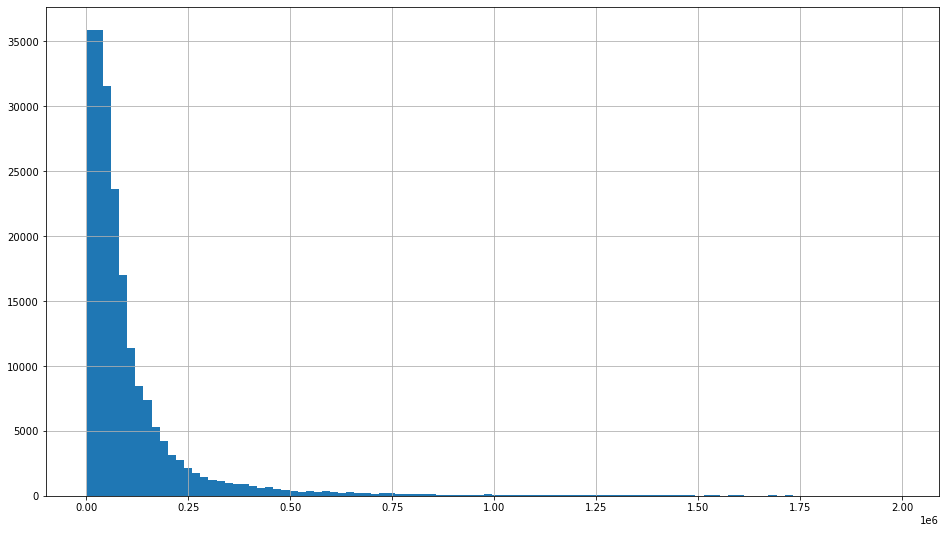

In [343]:
df['per_square_meter_price'].hist(bins=100);

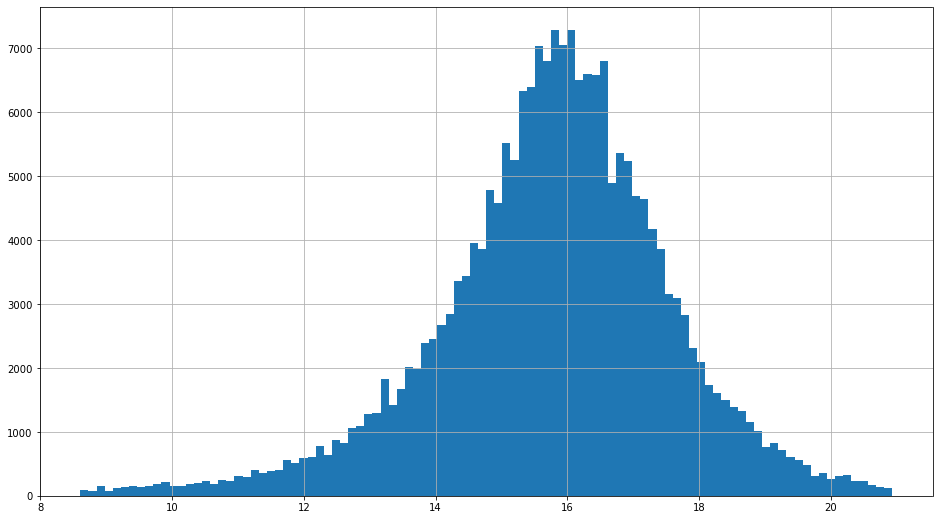

In [344]:
df['per_square_meter_price'].apply(log2).hist(bins=100);

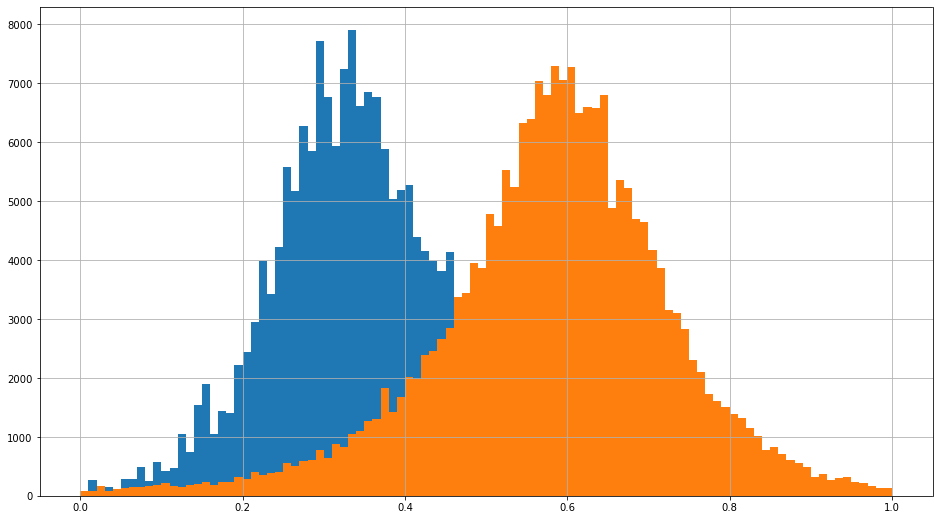

In [345]:
def norm(col, beg=-1e9, end=1e18):
    min_v = col[(beg < col) & (col < end)].min()
    max_v = col[(beg < col) & (col < end)].max()
    col = (col - min_v) / (max_v - min_v)
    col[col > 1] = 1
    col[col < 0] = 0
    return col


norm(df['total_square'].apply(log2)).hist(bins=100);
norm(df['per_square_meter_price'].apply(log2)).hist(bins=100);

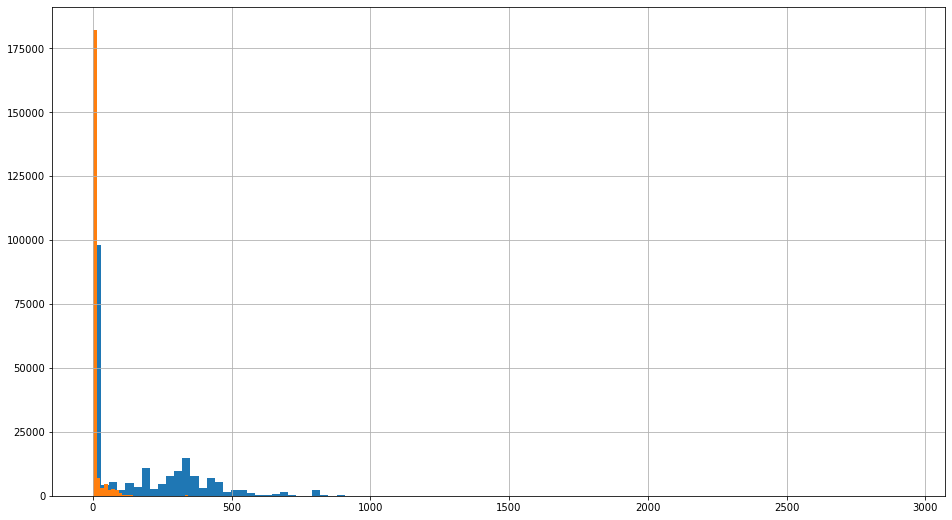

In [346]:
df['osm_subway_closest_dist'].hist(bins=100);
df['osm_train_stop_closest_dist'].hist(bins=100);

In [347]:
print("-----------osm_subway_closest_dist---------")
edge_value = 1000
print(len(df[df.osm_subway_closest_dist > edge_value]))
print(len(df))
print(len(df[df.osm_subway_closest_dist > edge_value]) / len(df))
print("-----------osm_train_stop_closest_dist---------")
edge_value = 200
print(len(df[df.osm_train_stop_closest_dist > edge_value]))
print(len(df))
print(len(df[df.osm_train_stop_closest_dist > edge_value]) / len(df))

-----------osm_subway_closest_dist---------
508
206474
0.002460358204907155
-----------osm_train_stop_closest_dist---------
725
206474
0.003511337989286787


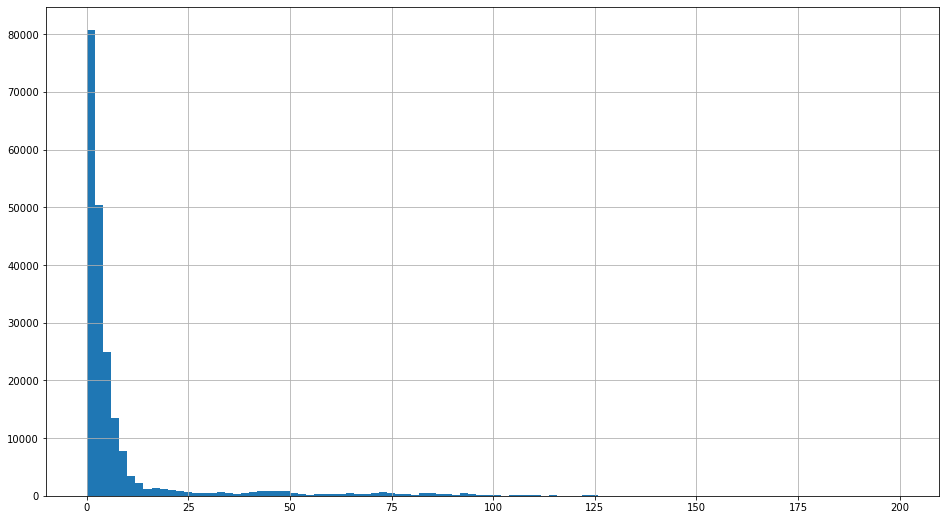

In [348]:
df[df.osm_train_stop_closest_dist < 200].osm_train_stop_closest_dist.hist(bins=100);

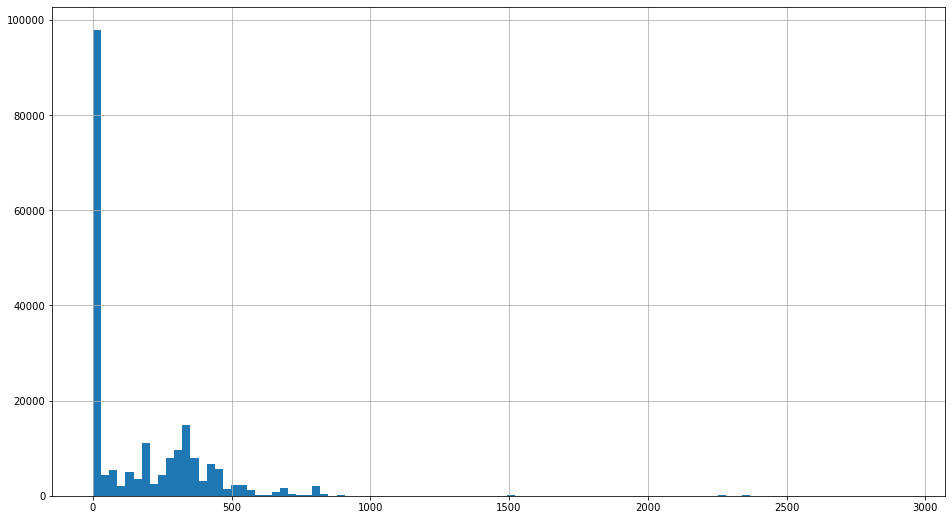

In [349]:
df.osm_subway_closest_dist.hist(bins=100);

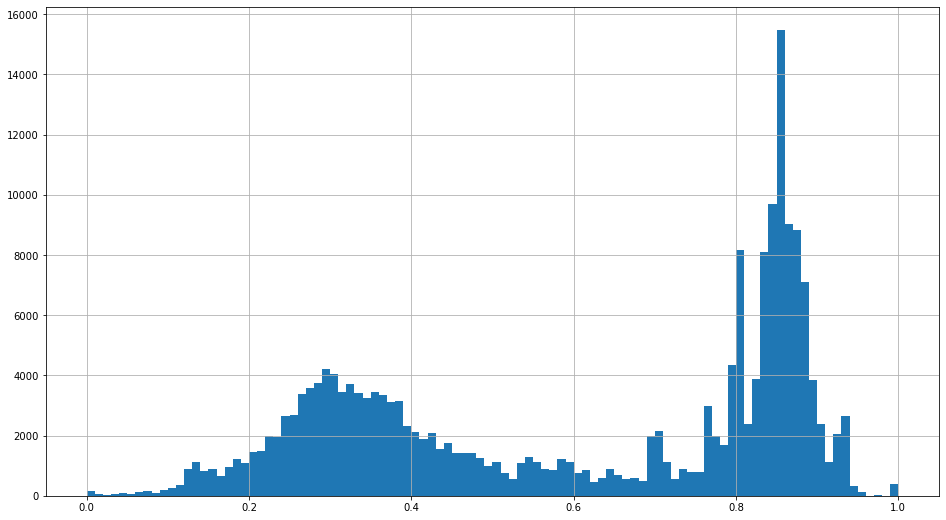

In [350]:

# df.osm_subway_closest_dist.apply(log2).hist(bins=100);
norm(df.osm_subway_closest_dist.apply(log2), beg=log2(0.03), end=log2(2000)).hist(bins=100);
# norm(df[(0.05 < df.osm_train_stop_closest_dist) & (df.osm_train_stop_closest_dist < 200)].osm_train_stop_closest_dist.apply(log2)).hist(bins=100);

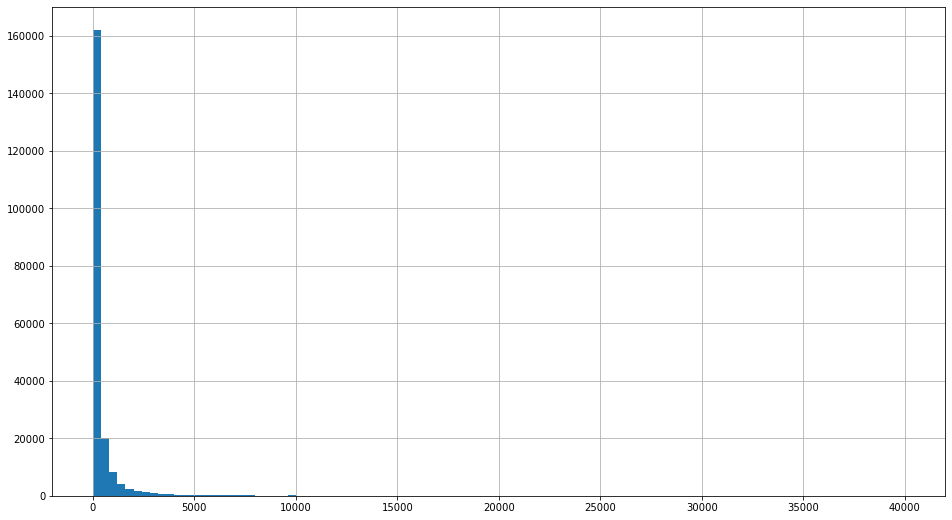

In [351]:
df.total_square.hist(bins=100);

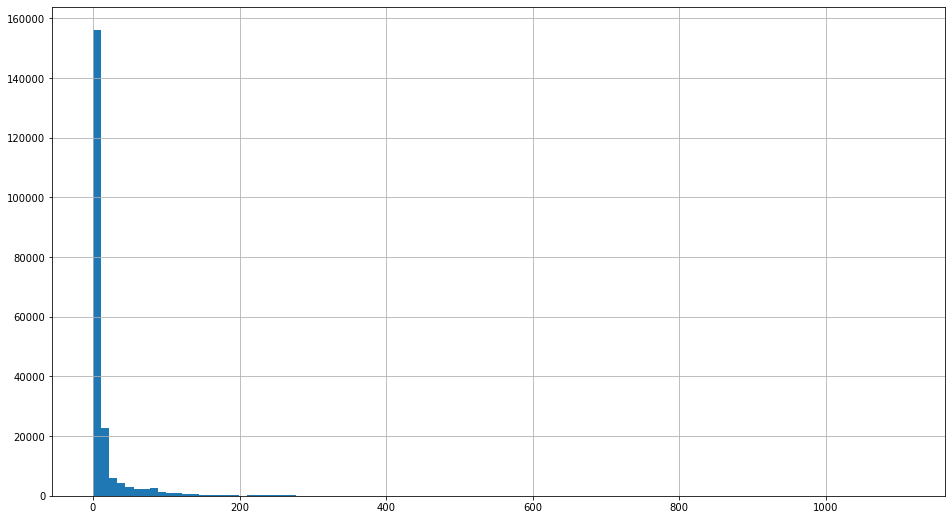

In [352]:
df.osm_city_closest_dist.hist(bins=100);

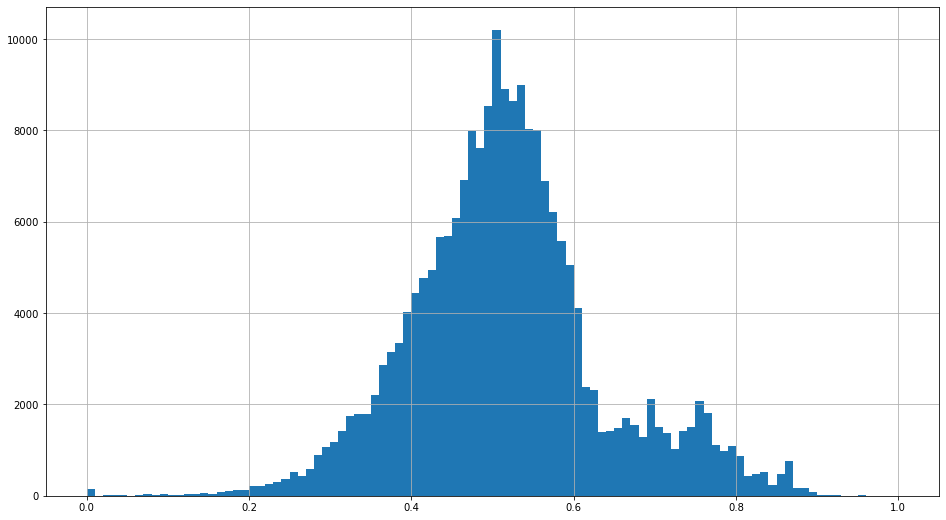

In [353]:
norm(df.osm_city_closest_dist.apply(log2), beg=log2(0.02)).hist(bins=100);

# Проверка результатов

In [354]:
df = df.assign(
    per_square_meter_price=df.per_square_meter_price.apply(log2),
    total_square=norm(df.total_square.apply(log2)),
    osm_train_stop_closest_dist=norm(df.osm_train_stop_closest_dist.apply(log2), end=log2(200)),
    osm_subway_closest_dist=norm(df.osm_subway_closest_dist.apply(log2), beg=log2(0.03), end=log2(2000)),
    is_msk=np.where((df['city'] == "Москва") | (df['region'] == "Москва"), 1, 0),
    is_spb=np.where((df['city'] == "Санкт-Петербург") | (df['region'] == "Санкт-Петербург"), 1, 0),
    is_city_mil_nearby=np.where((df['osm_city_nearest_population'] > 1e6), 1, 0),
    osm_city_closest_dist=norm(df.osm_city_closest_dist.apply(log2), beg=log2(0.02)),
)
params = ['total_square', 'osm_subway_closest_dist', 'osm_train_stop_closest_dist', 'osm_city_closest_dist', 'is_msk',
          'is_spb', 'is_city_mil_nearby']
target_col = 'per_square_meter_price'
df = df[params + [target_col]]

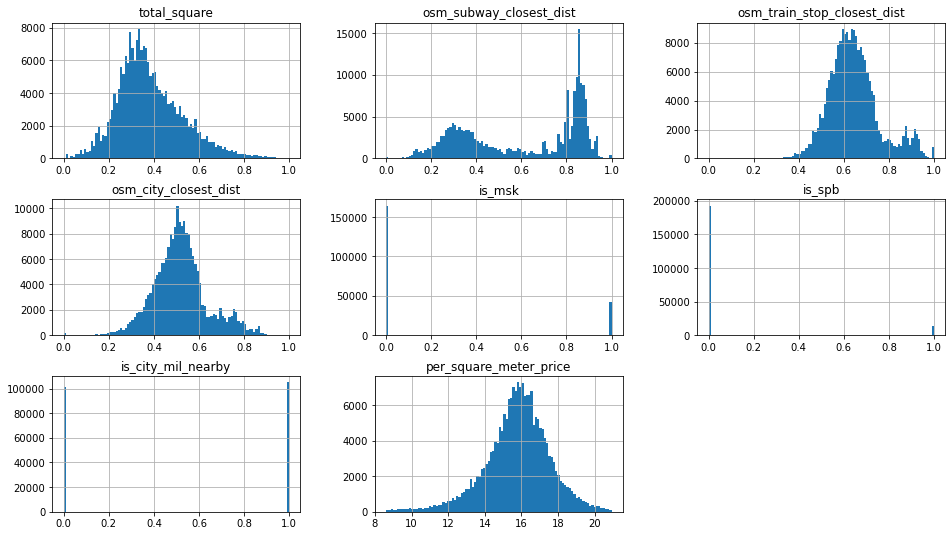

In [356]:
df.hist(bins=100);

In [357]:
full = df
train, test = train_test_split(df, test_size=0.2)

train_x, train_y = train.drop(target_col, axis=1), train[target_col]
test_x, test_y = test.drop(target_col, axis=1), test[target_col]

In [358]:
model = LinearRegression()
model.fit(train_x, train_y)

pred = model.predict(test_x)
mean_absolute_percentage_error(2 ** test_y, 2 ** pred) * 100

2.887219078491367

# Генерация результатов

In [359]:
model = LinearRegression()
model.fit(full.drop(target_col, axis=1), full[target_col])

LinearRegression()

In [360]:
test_data = pd.read_csv('test_x.csv')
test_data = test_data.assign(
    total_square=norm(test_data.total_square.apply(log2)),
    osm_train_stop_closest_dist=norm(test_data.osm_train_stop_closest_dist.apply(log2), end=log2(200)),
    osm_subway_closest_dist=norm(test_data.osm_subway_closest_dist.apply(log2), beg=log2(0.03), end=log2(2000)),
    is_msk=np.where((test_data['city'] == "Москва") | (test_data['region'] == "Москва"), 1, 0),
    is_spb=np.where((test_data['city'] == "Санкт-Петербург") | (test_data['region'] == "Санкт-Петербург"), 1, 0),
    is_city_mil_nearby=np.where((test_data['osm_city_nearest_population'] > 1e6), 1, 0),
    osm_city_closest_dist=norm(test_data.osm_city_closest_dist.apply(log2), beg=log2(0.02)),
)

test_data = test_data[params]

In [361]:
def reverse(x):
    return 2 ** x

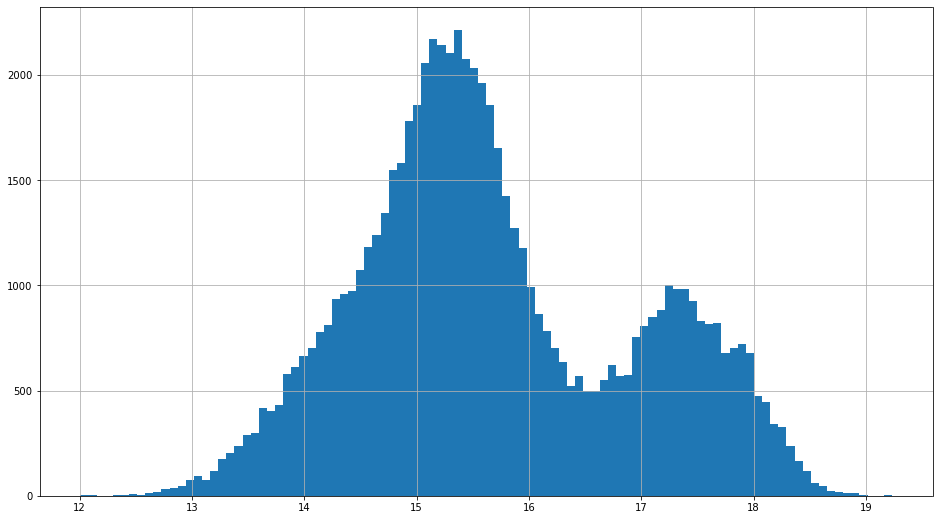

In [362]:
result = pd.DataFrame(model.predict(test_data), columns=['per_square_meter_price'])
result.per_square_meter_price.hist(bins=100)
result = result.assign(
    per_square_meter_price=result.per_square_meter_price.apply(reverse)
)
result.to_csv('result.csv', index_label="id")

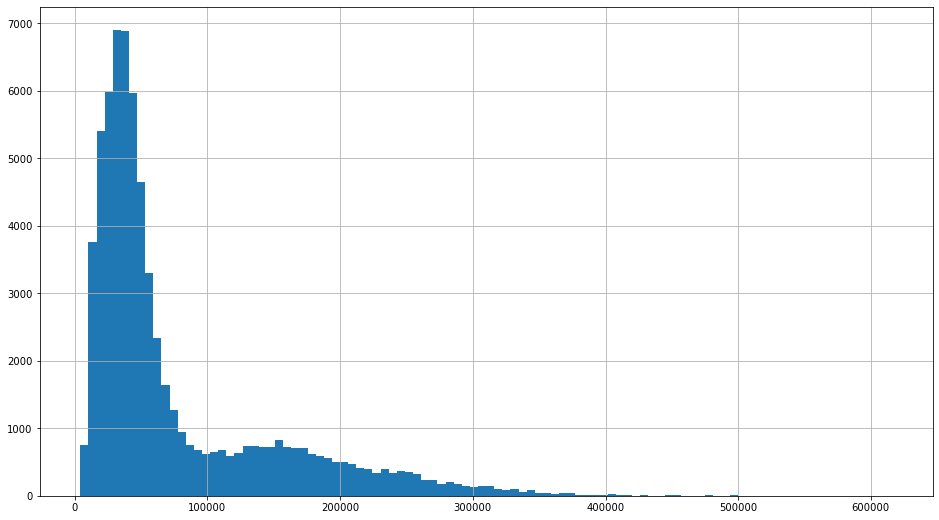

In [363]:
result.per_square_meter_price.hist(bins=100);

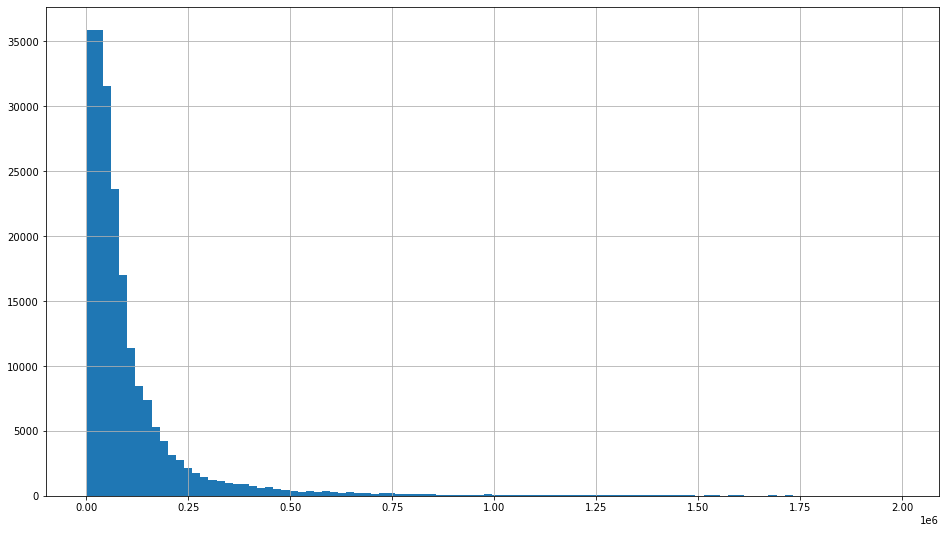

In [364]:
full = full.assign(
    per_square_meter_price=full.per_square_meter_price.apply(reverse)
)
full.per_square_meter_price.hist(bins=100);